 ## HW4 - EuroSAT Land Use and Land Cover Classification using Deep Learning
 
In this homework your task is to implement deep learning models to solve a typical problem in satellite imaging  using a benchmark dataset. The homework was designed to make you work on increasingly more complex models. We hope that the homework will be very helpful to improve your skills and knowledge in deep learning!


### S1:

- Visit the EuroSAT data description page and download the data: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

- Convert each RGB image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)


In [1]:
!pip install tensorflow

In [2]:
## import packages
import os, cv2
import numpy as np 
import pandas as pd 
import math
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import PIL
import PIL.Image

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2, l1
import math

In [3]:
## Mount drive folder
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
imgs = []
path = "/content/drive/MyDrive/Grad School/Penn_MUSA/Spring2022/650_RemoteSensing/Homework/HW4/Data/EuroSAT_RGB/"
labels = os.listdir(path)

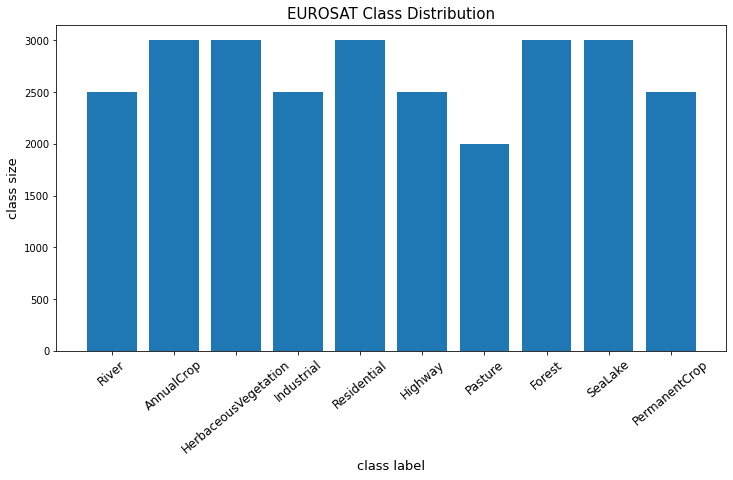

In [5]:
# plot class distributions of whole dataset
counts = {}

for l in labels:
    counts[l] = len(os.listdir(os.path.join(path, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [6]:
## Get all of the class names from their directory names
classNames = os.listdir(path)

## Find the total number of classes
numClass = len(classNames)

## Identify the number of images in each class by reading the number of files
## in each class directory
lenClass = np.zeros(numClass)
for i in np.arange(0, numClass):
  lenClass[i] = len(os.listdir(path + '/' + classNames[i]))
print(classNames)
print(lenClass)

['River', 'AnnualCrop', 'HerbaceousVegetation', 'Industrial', 'Residential', 'Highway', 'Pasture', 'Forest', 'SeaLake', 'PermanentCrop']
[2500. 3000. 3000. 2500. 3000. 2500. 2000. 3000. 3000. 2500.]


(64, 64, 3)

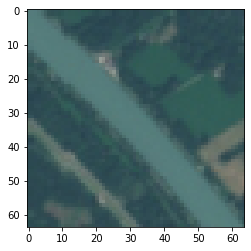

In [7]:
## Find the shape of one image so we can load the rest
imgSel = path + '/' + classNames[0] + '/' + os.listdir(path + '/' + classNames[0])[0]
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img))
np.asarray(img).shape

In [8]:
## numImg is the total number of images in the dataset
numImg  = int(lenClass.sum())

## numPixels is the number of pixels in each image
numPixels = np.asarray(img).shape # 64 x 64 x 3 px in rgb img
numGrayPixels = np.prod(np.asarray(img.convert('L')).shape) # 4096 px in grayscale

In [9]:
## Initialize arrays for Grayscale imgs
X = np.zeros([numImg, numGrayPixels])
y = np.zeros(numImg)

## Initialize arrays for RGB dataset
X_RGB = np.zeros([numImg, 64, 64, 3])
y_RGB = np.zeros(numImg)

In [10]:
## Read images vectors into X array
## Read image labels into y array

imgInd=0
for i in np.arange(0, numClass):
  className = classNames[i]
  for imgName in os.listdir(path + '/' + className):
    img = PIL.Image.open(path + '/' + className + '/' + imgName, 'r')

    imgGry = img.convert('L') # convert imgs to grayscale
    imgVec = np.asarray(imgGry).flatten() #flatten img to np array, rather than img matrix

    # Append to RGB dataset
    X_RGB[imgInd,:] = img
    y_RGB[imgInd] = i

    # Append to grayscale dataset
    X[imgInd,:] = imgVec
    y[imgInd] = i

    imgInd = imgInd + 1

print(X.shape)
print(y.shape)
print(X_RGB.shape)
print(y_RGB.shape)

(27000, 4096)
(27000,)
(27000, 64, 64, 3)
(27000,)


In [11]:
## Create Train/Test split 50:50 split
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, stratify = y)

print(X1.shape)
print(X2.shape)

(13500, 4096)
(13500, 4096)


### S2:

- Implement a first deep learning model (M.1) using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer). 

Q2.1: Calculate classification accuracy on the test data.  

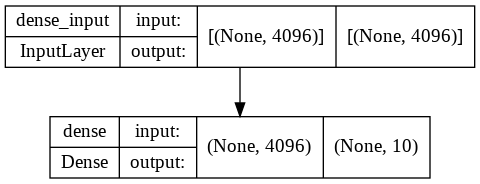

In [12]:
m1 = Sequential()
m1.add(Dense(10, input_shape=(4096,)))

plot_model(m1, show_shapes=True, show_layer_names=True)

In [13]:
## Compile the model
opt = Adam(learning_rate=0.001)
NUM_EPOCH = 50
B_SIZE = 275


m1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [14]:
## Train the model
md1_tr = m1.fit(X1, y1, batch_size=B_SIZE, epochs=NUM_EPOCH, shuffle=True, validation_data=(X2, y2))

Epoch 1/50
50/50 [==============================] - 2s 28ms/step - loss: -32.7431 - accuracy: 0.0924 - val_loss: -40.6309 - val_accuracy: 0.0925
Epoch 2/50
50/50 [==============================] - 1s 20ms/step - loss: -40.6321 - accuracy: 0.0926 - val_loss: -40.6309 - val_accuracy: 0.0925
Epoch 3/50
50/50 [==============================] - 1s 19ms/step - loss: -40.6321 - accuracy: 0.0926 - val_loss: -40.6309 - val_accuracy: 0.0925
Epoch 4/50
50/50 [==============================] - 1s 20ms/step - loss: -40.6321 - accuracy: 0.0926 - val_loss: -40.6309 - val_accuracy: 0.0925
Epoch 5/50
50/50 [==============================] - 1s 19ms/step - loss: -40.6321 - accuracy: 0.0926 - val_loss: -40.6309 - val_accuracy: 0.0925
Epoch 6/50
50/50 [==============================] - 1s 17ms/step - loss: -40.6321 - accuracy: 0.0926 - val_loss: -40.6309 - val_accuracy: 0.0925
Epoch 7/50
50/50 [==============================] - 1s 17ms/step - loss: -40.6321 - accuracy: 0.0926 - val_loss: -40.6309 - val_ac

In [15]:
score = m1.evaluate(X2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: -40.63085174560547
Test accuracy: 0.09251851588487625


### S3:

- Implement a second deep learning model (M.2) adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model. 

Q3.1: Calculate classification accuracy on the test data.  

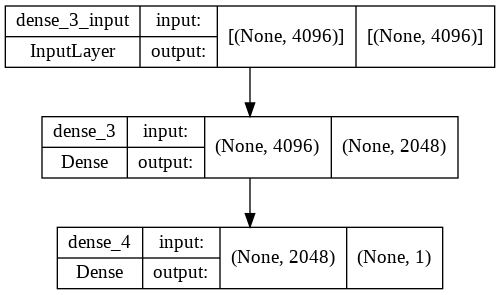

In [18]:
m2 = Sequential()
m2.add(Dense(2048, input_shape=(4096,), activation='relu'))
m2.add(Dense(1, activation='softmax'))

plot_model(m2, show_shapes=True, show_layer_names=True)

In [19]:
## Compile the model
m2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Train the model
md2_tr = m2.fit(X1, y1, batch_size=B_SIZE, epochs=NUM_EPOCH, shuffle=True, validation_data=(X2, y2))

Epoch 1/50
50/50 [==============================] - 24s 458ms/step - loss: 0.0000e+00 - accuracy: 0.1111 - val_loss: 0.0000e+00 - val_accuracy: 0.1111
Epoch 2/50
50/50 [==============================] - 13s 265ms/step - loss: 0.0000e+00 - accuracy: 0.1111 - val_loss: 0.0000e+00 - val_accuracy: 0.1111
Epoch 3/50
50/50 [==============================] - 13s 266ms/step - loss: 0.0000e+00 - accuracy: 0.1111 - val_loss: 0.0000e+00 - val_accuracy: 0.1111
Epoch 4/50
50/50 [==============================] - 13s 265ms/step - loss: 0.0000e+00 - accuracy: 0.1111 - val_loss: 0.0000e+00 - val_accuracy: 0.1111
Epoch 5/50
50/50 [==============================] - 13s 266ms/step - loss: 0.0000e+00 - accuracy: 0.1111 - val_loss: 0.0000e+00 - val_accuracy: 0.1111
Epoch 6/50
50/50 [==============================] - 13s 264ms/step - loss: 0.0000e+00 - accuracy: 0.1111 - val_loss: 0.0000e+00 - val_accuracy: 0.1111
Epoch 7/50
50/50 [==============================] - 13s 269ms/step - loss: 0.0000e+00 - accura

In [20]:
score = m2.evaluate(X2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0
Test accuracy: 0.1111111119389534


### S4:

- Implement a third deep learning model (M.3) adding two additional fully connected hidden layers (with arbitrary number of nodes) for a total of four, as well as drop-out layers to the previous model. 

Q4.1: Calculate classification accuracy on the test data.

Q4.2: Compare against previous models. Which model was the "best"? Why?

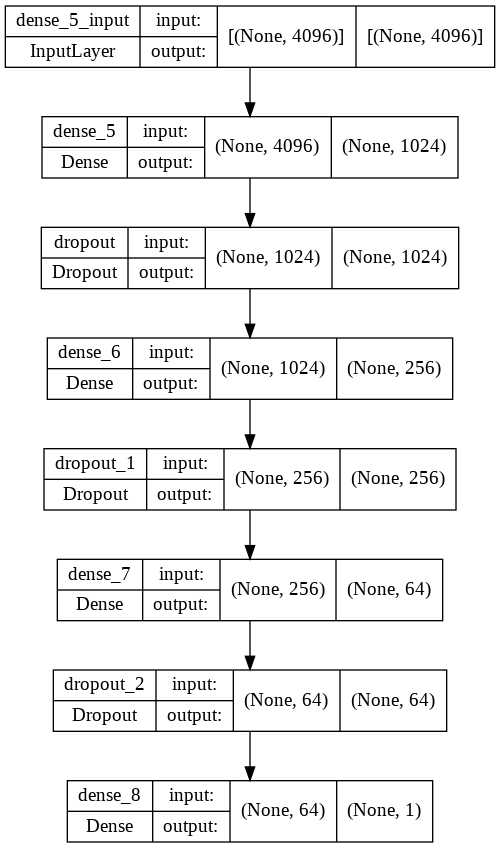

In [21]:
m3 = Sequential()
m3.add(Dense(1024, input_shape=(4096,)))
m3.add(Dropout(0.2))
m3.add(Dense(256))
m3.add(Dropout(0.2))
m3.add(Dense(64))
m3.add(Dropout(0.2))
m3.add(Dense(1))

plot_model(m3, show_shapes=True, show_layer_names=True)

In [22]:
## Compile the model
m3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Train the model
md3_tr = m3.fit(X1, y1, batch_size=B_SIZE, epochs=NUM_EPOCH, shuffle=True, validation_data=(X2, y2))

Epoch 1/50
50/50 [==============================] - 9s 163ms/step - loss: 5.3203e-07 - accuracy: 0.0987 - val_loss: 5.3203e-07 - val_accuracy: 0.0923
Epoch 2/50
50/50 [==============================] - 8s 157ms/step - loss: 5.3203e-07 - accuracy: 0.0982 - val_loss: 5.3203e-07 - val_accuracy: 0.0923
Epoch 3/50
50/50 [==============================] - 8s 158ms/step - loss: 5.3203e-07 - accuracy: 0.0931 - val_loss: 5.3203e-07 - val_accuracy: 0.0923
Epoch 4/50
50/50 [==============================] - 8s 157ms/step - loss: 5.3203e-07 - accuracy: 0.1013 - val_loss: 5.3203e-07 - val_accuracy: 0.0923
Epoch 5/50
50/50 [==============================] - 8s 156ms/step - loss: 5.3203e-07 - accuracy: 0.0974 - val_loss: 5.3203e-07 - val_accuracy: 0.0923
Epoch 6/50
50/50 [==============================] - 8s 159ms/step - loss: 5.3203e-07 - accuracy: 0.0939 - val_loss: 5.3203e-07 - val_accuracy: 0.0923
Epoch 7/50
50/50 [==============================] - 8s 157ms/step - loss: 5.3203e-07 - accuracy: 0.0

In [23]:
score = m3.evaluate(X2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 5.320266609487589e-07
Test accuracy: 0.0922962948679924


### S5:

- Take the original RGB images and do not vectorize them. Use these images as the data input for the following models (M.4 and M.5).
- Implement a fourth CNN model (M.4) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

Q5.1: Calculate classification accuracy on the test data.

Q5.2: Compare against previous models. Which model was the "best"? Why?

In [24]:
## Create Train/Test split 50:50 split
from sklearn.model_selection import train_test_split
X_RGB_1, X_RGB_2, y_RGB_1, y_RGB_2 = train_test_split(X_RGB, y_RGB, test_size=0.5, stratify = y_RGB)

print(X_RGB_1.shape)
print(X_RGB_2.shape)

(13500, 64, 64, 3)
(13500, 64, 64, 3)


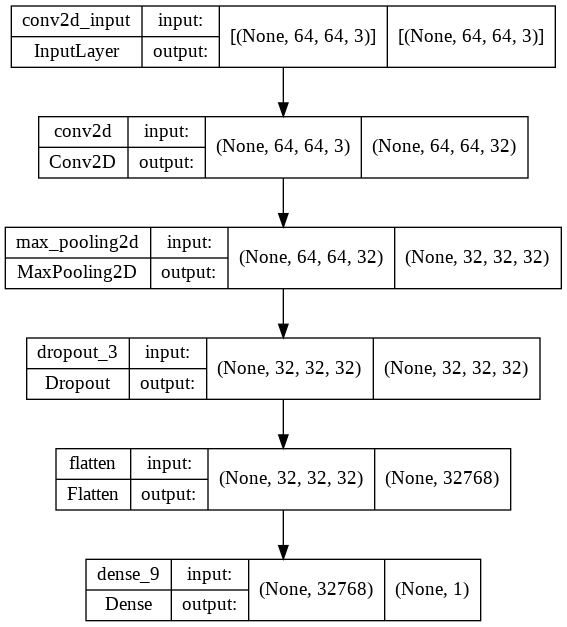

In [25]:
# Create DL model for RGB matrices
m4 = Sequential()
m4.add(Conv2D(32, (4, 4), padding='same', input_shape=(64,64,3), activation='relu'))
m4.add(MaxPooling2D(pool_size=(2, 2))) #5x5
m4.add(Dropout(0.25))

m4.add(Flatten())
m4.add(Dense(1, activation='relu'))
    
plot_model(m4, show_shapes=True, show_layer_names=True)

In [ ]:
## Compile the model
m4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Train the model
md4_tr = m4.fit(X_RGB_1, y_RGB_1, batch_size=B_SIZE, epochs=NUM_EPOCH, shuffle=True, validation_data=(X_RGB_2, y_RGB_2))

Epoch 1/50
50/50 [==============================] - 47s 928ms/step - loss: nan - accuracy: 0.0926 - val_loss: nan - val_accuracy: 0.0926
Epoch 2/50
50/50 [==============================] - 47s 937ms/step - loss: nan - accuracy: 0.0926 - val_loss: nan - val_accuracy: 0.0926
Epoch 3/50
50/50 [==============================] - 46s 924ms/step - loss: nan - accuracy: 0.0926 - val_loss: nan - val_accuracy: 0.0926
Epoch 4/50
50/50 [==============================] - 46s 922ms/step - loss: nan - accuracy: 0.0926 - val_loss: nan - val_accuracy: 0.0926
Epoch 5/50
50/50 [==============================] - 46s 932ms/step - loss: nan - accuracy: 0.0926 - val_loss: nan - val_accuracy: 0.0926
Epoch 6/50
50/50 [==============================] - 46s 930ms/step - loss: nan - accuracy: 0.0926 - val_loss: nan - val_accuracy: 0.0926
Epoch 7/50
50/50 [==============================] - 47s 945ms/step - loss: nan - accuracy: 0.0926 - val_loss: nan - val_accuracy: 0.0926
Epoch 8/50
50/50 [=======================

In [ ]:
score = m4.evaluate(X2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### S6:

- Using RGB images from S5, implement a fifth deep learning model (M.5) targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, as well as pre-trained models for transfer learning. 

Q6.1: Describe the model you built, and why you chose it.

Q6.2: Calculate classification accuracy on the test data.

Q6.3: Compare against previous models. Which model was the "best"? Why?

Q6.4: What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.

### S7:

- Apply your best model on multispectral images. You may use whichever image channels you wish, so long as you use more than just RGB (although you are not required to use any color channels).

Q7.1: Calculate classification accuracy on the test data.

Q7.2: Compare against results using RGB images.